# FE15 - Signal classification

## Example Signal

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd

t = pd.date_range(start='2020-09-23 15:00',
                 end='2020-09-23 15:02',
                 periods=120*100+1)
df = pd.DataFrame(index=t)
delta_t = df.index - df.index[0]
df['seconds'] = delta_t.seconds + delta_t.microseconds/1e6
np.random.seed(2020)
df['signal'] = np.sin(df.seconds/10 * 2 *np.pi) + 0.5*np.random.randn(df.shape[0])
idx = np.asarray(np.floor(df.reset_index().index / 100).values, np.int64)
df['window_idx'] = ['s{:03}'.format(i) for i in idx]

In [3]:
df.head()

,seconds,signal,window_idx
2020-09-23 15:00:00.000,0.00,-0.884423,s000
2020-09-23 15:00:00.010,0.01,0.044059,s000
2020-09-23 15:00:00.020,0.02,-0.552749,s000
2020-09-23 15:00:00.030,0.03,-0.306867,s000
2020-09-23 15:00:00.040,0.04,-0.421428,s000


/Users/akem134/opt/anaconda3/envs/dslab/bin/python
{'numpy': '1.20.3', 'pandas': '1.4.3', 'seaborn': '0.11.2', 'sklearn': '1.0.2', 'matplotlib': '3.5.1'}


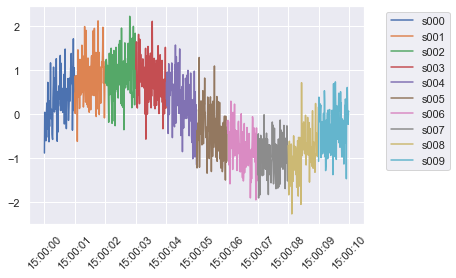

In [4]:
import dslab
import matplotlib.pyplot as plt

def plot_first_ten(df, style='-'):
    for idx in np.unique(df['window_idx'])[:10]:
        plt.plot(df.signal[df.window_idx == idx], style, label=idx)
        plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
plot_first_ten(df)

In [5]:
df.tail()

,seconds,signal,window_idx
2020-09-23 15:01:59.960,119.96,0.552865,s119
2020-09-23 15:01:59.970,119.97,0.259067,s119
2020-09-23 15:01:59.980,119.98,-1.007435,s119
2020-09-23 15:01:59.990,119.99,0.304607,s119
2020-09-23 15:02:00.000,120.00,0.027652,s120


In [6]:
import tsfresh
tsfresh.__version__

'0.19.0'

In [7]:
from tsfresh.feature_extraction import settings

In [8]:
from tsfresh.feature_extraction.settings import MinimalFCParameters
minimal_fc = MinimalFCParameters()

In [9]:
from tsfresh.feature_extraction import extract_features

In [10]:
X = extract_features(df.iloc[:-1], column_id='window_idx', column_sort='seconds',
                    default_fc_parameters=minimal_fc)

Feature Extraction: 100%|███████████████████████| 40/40 [00:02<00:00, 13.82it/s]


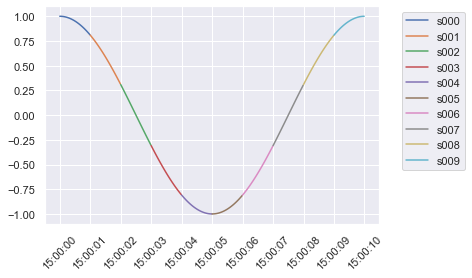

In [11]:
y = df.copy()
y['signal'] = np.cos(df.seconds/10 * 2 *np.pi)
plot_first_ten(y)

In [12]:
target = y.groupby('window_idx').signal.mean()[:-1] > 0
target

window_idx
s000     True
s001     True
s002     True
s003    False
s004    False
        ...  
s115    False
s116    False
s117    False
s118     True
s119     True
Name: signal, Length: 120, dtype: bool

In [13]:
from tsfresh.transformers import FeatureSelector

select = FeatureSelector()
select.fit(X, target)

FeatureSelector()

In [14]:
select.relevant_features

['signal__median',
 'signal__sum_values',
 'signal__mean',
 'signal__minimum',
 'signal__maximum']

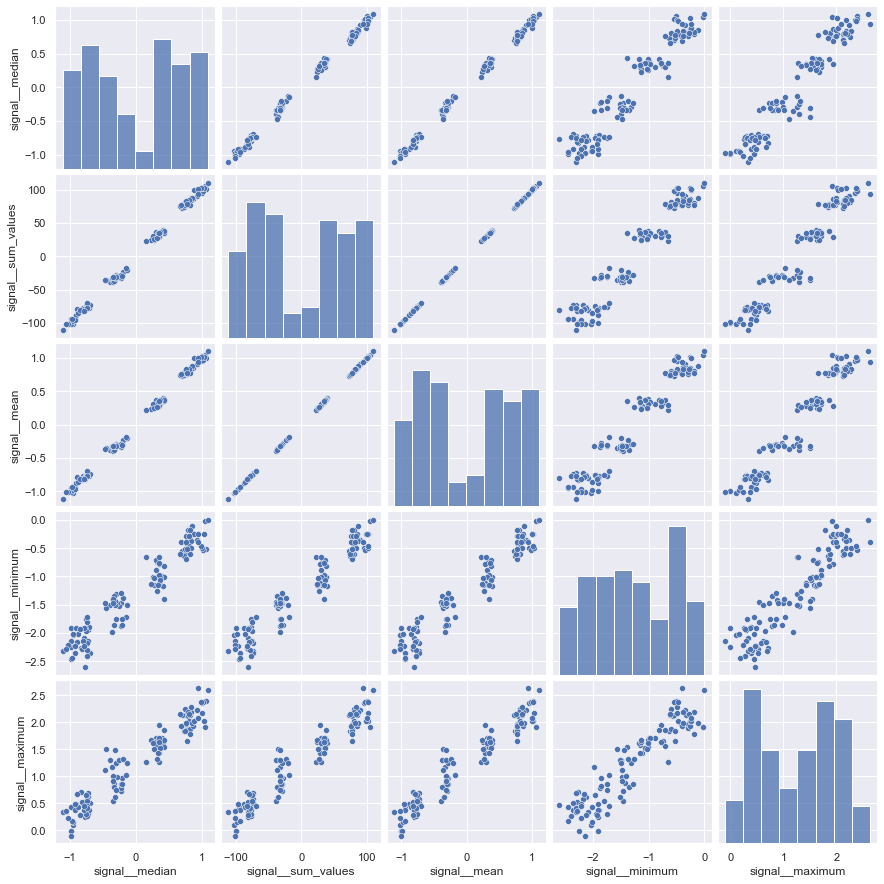

In [15]:
import seaborn as sns
sns.pairplot(X[select.relevant_features])


# Logistic regression

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
logreg = LogisticRegression()
logreg.fit(X[select.relevant_features], target)

LogisticRegression()

In [18]:
# in-sample evaluation
from sklearn.metrics import roc_auc_score

roc_auc_score(target, logreg.predict_proba(X[select.relevant_features])[:,1])

0.6805555555555556

In [19]:
logreg.coef_

array([[ 2.14045939e-01,  9.87371249e-03,  9.87371249e-05,
        -2.19550490e-02, -3.29878090e-01]])

In [20]:
pd.Series(logreg.coef_.flatten(), 
          index=select.relevant_features)

signal__median        0.214046
signal__sum_values    0.009874
signal__mean          0.000099
signal__minimum      -0.021955
signal__maximum      -0.329878
dtype: float64

In [21]:
logreg_l1 = LogisticRegression(penalty='l1', solver='saga')
logreg_l1.fit(X[select.relevant_features], target)

LogisticRegression(penalty='l1', solver='saga')

In [22]:
pd.Series(logreg_l1.coef_.flatten(), 
          index=select.relevant_features)

signal__median        0.000000
signal__sum_values    0.008473
signal__mean          0.000000
signal__minimum       0.000000
signal__maximum       0.000000
dtype: float64

In [23]:
X['signal__sum_values']

s000     30.428823
s001     78.822224
s002     90.612638
s003     78.136326
s004     32.253874
           ...    
s115    -30.456224
s116    -77.592367
s117   -101.479997
s118    -81.994461
s119    -31.954103
Name: signal__sum_values, Length: 120, dtype: float64

In [24]:
target

window_idx
s000     True
s001     True
s002     True
s003    False
s004    False
        ...  
s115    False
s116    False
s117    False
s118     True
s119     True
Name: signal, Length: 120, dtype: bool

<AxesSubplot:xlabel='signal__sum_values', ylabel='signal'>

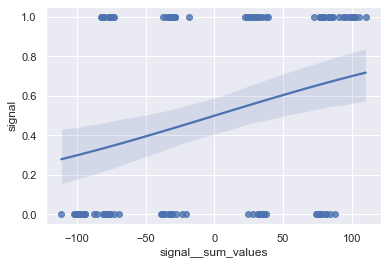

In [25]:
sns.regplot(X['signal__sum_values'], target, logistic=True)

## Efficient FC Parameters

In [26]:
from tsfresh.feature_extraction.settings import EfficientFCParameters

efficient_fc = EfficientFCParameters()  # Create dictionary
efficient = sorted(efficient_fc.keys())  # Sort list of dictionary keys
print('Number of feature calculators: ', len(efficient))
print(efficient)

Number of feature calculators:  74
['abs_energy', 'absolute_maximum', 'absolute_sum_of_changes', 'agg_autocorrelation', 'agg_linear_trend', 'ar_coefficient', 'augmented_dickey_fuller', 'autocorrelation', 'benford_correlation', 'binned_entropy', 'c3', 'change_quantiles', 'cid_ce', 'count_above', 'count_above_mean', 'count_below', 'count_below_mean', 'cwt_coefficients', 'energy_ratio_by_chunks', 'fft_aggregated', 'fft_coefficient', 'first_location_of_maximum', 'first_location_of_minimum', 'fourier_entropy', 'friedrich_coefficients', 'has_duplicate', 'has_duplicate_max', 'has_duplicate_min', 'index_mass_quantile', 'kurtosis', 'large_standard_deviation', 'last_location_of_maximum', 'last_location_of_minimum', 'lempel_ziv_complexity', 'length', 'linear_trend', 'linear_trend_timewise', 'longest_strike_above_mean', 'longest_strike_below_mean', 'matrix_profile', 'max_langevin_fixed_point', 'maximum', 'mean', 'mean_abs_change', 'mean_change', 'mean_n_absolute_max', 'mean_second_derivative_centr

In [27]:
from tsfresh.feature_extraction import extract_features

X_eff = extract_features(df.iloc[:-1], column_id='window_idx', column_sort='seconds',
                    default_fc_parameters=efficient_fc)

Feature Extraction: 100%|███████████████████████| 40/40 [00:03<00:00, 11.16it/s]


In [28]:
X_eff.shape

(120, 788)

In [29]:
X_eff_nona = X_eff.dropna(axis=1)
X_eff_nona

,signal__variance_larger_than_standard_deviation,signal__has_duplicate_max,signal__has_duplicate_min,signal__has_duplicate,signal__sum_values,signal__abs_energy,signal__mean_abs_change,signal__mean_change,signal__mean_second_derivative_central,signal__median,...,signal__fourier_entropy__bins_3,signal__fourier_entropy__bins_5,signal__fourier_entropy__bins_10,signal__fourier_entropy__bins_100,signal__permutation_entropy__dimension_3__tau_1,signal__permutation_entropy__dimension_4__tau_1,signal__permutation_entropy__dimension_5__tau_1,signal__permutation_entropy__dimension_6__tau_1,signal__permutation_entropy__dimension_7__tau_1,signal__mean_n_absolute_max__number_of_maxima_7
s000,0.0,0.0,0.0,0.0,30.428823,36.945121,0.489540,0.010145,-0.009538,0.300985,...,0.818379,1.219372,1.792935,3.253409,1.757630,2.945049,3.993805,4.437136,4.543295,1.360660
s001,0.0,0.0,0.0,0.0,78.822224,88.501960,0.583033,0.003370,0.008502,0.723670,...,0.793008,1.257694,1.918903,3.454513,1.781846,3.069378,4.156190,4.510099,4.528547,1.938590
s002,0.0,0.0,0.0,0.0,90.612638,109.157827,0.622913,-0.001189,-0.008340,0.927061,...,0.751924,1.164058,1.790218,3.367661,1.760174,3.070720,4.170631,4.480914,4.543295,1.894972
s003,0.0,0.0,0.0,0.0,78.136326,85.918185,0.645401,-0.001737,0.002223,0.788755,...,0.443757,0.615767,1.125203,2.845238,1.748513,2.986997,3.952112,4.411528,4.513799,1.703714
s004,0.0,0.0,0.0,0.0,32.253874,40.952312,0.609907,-0.015080,-0.008952,0.303399,...,0.670004,1.189950,1.728110,3.405103,1.779503,3.072033,4.118319,4.480914,4.543295,1.291651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s115,0.0,0.0,0.0,0.0,-30.456224,40.560379,0.644300,-0.012988,0.003850,-0.207802,...,0.677092,1.193019,1.822001,3.508878,1.739914,2.933882,3.936950,4.417036,4.543295,1.489425
s116,0.0,0.0,0.0,0.0,-77.592367,85.635669,0.539666,-0.001032,0.000935,-0.748049,...,0.836203,1.352749,1.916913,3.388181,1.774658,3.059951,4.132760,4.495507,4.543295,1.696590
s117,0.0,0.0,0.0,0.0,-101.479997,125.283528,0.583537,-0.011422,0.000558,-1.054358,...,0.493532,0.940185,1.570029,3.112544,1.782704,3.103654,4.080448,4.495507,4.543295,1.874395
s118,0.0,0.0,0.0,0.0,-81.994461,94.917333,0.573589,0.004275,-0.004849,-0.782170,...,0.695363,1.147924,1.797625,3.476390,1.777851,2.979411,4.074998,4.524692,4.543295,1.819460


In [30]:
select_eff = FeatureSelector()
select_eff.fit(X_eff_nona, target)

FeatureSelector()

In [31]:
X_eff_rel = select_eff.transform(X_eff_nona)
X_eff_rel.shape

(120, 50)

In [32]:
X_eff_rel.head()

,"signal__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""mean""","signal__linear_trend__attr_""rvalue""","signal__linear_trend_timewise__attr_""rvalue""","signal__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","signal__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","signal__linear_trend__attr_""slope""","signal__linear_trend_timewise__attr_""slope""","signal__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""mean""","signal__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""","signal__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""mean""",...,signal__quantile__q_0.6,"signal__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)",signal__quantile__q_0.4,"signal__fft_coefficient__attr_""imag""__coeff_4",signal__quantile__q_0.7,signal__median,"signal__fft_coefficient__attr_""real""__coeff_0",signal__sum_values,signal__mean,signal__quantile__q_0.9
s000,0.693553,0.448293,0.448293,0.040685,0.785542,0.008172,2941.759541,0.080526,0.046477,0.406820,...,0.392203,-0.958780,0.150628,0.181519,0.590502,0.300985,30.428823,30.428823,0.304288,1.061297
s001,0.407091,0.215928,0.215928,0.018682,0.616639,0.003841,1382.928071,0.038866,0.018299,0.250007,...,0.863135,0.004755,0.608804,0.812062,1.008775,0.723670,78.822224,78.822224,0.788222,1.442778
s002,0.385640,0.178390,0.178390,0.015845,0.591020,0.003214,1157.124947,0.031947,0.032852,0.142985,...,1.054535,0.643929,0.803941,1.710065,1.129242,0.927061,90.612638,90.612638,0.906126,1.618149
s003,-0.408695,-0.162657,-0.162657,-0.014072,-0.500074,-0.002810,-1011.545321,-0.027620,-0.020206,-0.087975,...,0.917760,0.871064,0.634214,-1.153496,1.074740,0.788755,78.136326,78.136326,0.781363,1.380214
s004,-0.665810,-0.365600,-0.365600,-0.035026,-0.767296,-0.007000,-2520.120402,-0.068274,-0.024905,-0.375910,...,0.460487,0.282831,0.193483,3.414602,0.655015,0.303399,32.253874,32.253874,0.322539,0.982969


In [33]:
logreg.fit(X_eff_rel, target)

LogisticRegression()

In [34]:
roc_auc_score(target, logreg.predict_proba(X_eff_rel)[:,1])

0.9991666666666666

In [35]:
pd.Series(logreg.coef_[0,:],
          index=X_eff_rel.columns).sort_values(ascending=False).head()

signal__fft_coefficient__attr_"imag"__coeff_2                          0.918408
signal__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"     0.284019
signal__fft_coefficient__attr_"imag"__coeff_3                          0.271059
signal__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"    0.267512
signal__c3__lag_1                                                      0.249787
dtype: float64

In [36]:
pd.Series(logreg.coef_[0,:],
          index=X_eff_rel.columns).sort_values(ascending=False).tail()

signal__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)       -0.162426
signal__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"    -0.172778
signal__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"    -0.239411
signal__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"   -0.241446
signal__fft_coefficient__attr_"imag"__coeff_5                        -0.510976
dtype: float64

## Slide FE15 p. 5

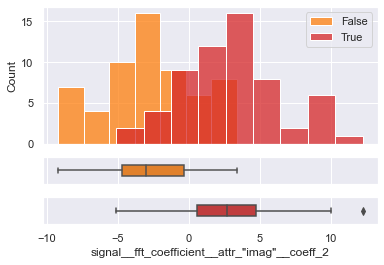

In [37]:
from dslab.visualization.visualize import distributions

phi_1 = 'signal__fft_coefficient__attr_"imag"__coeff_2'
distributions(X_eff[phi_1], target, colors=sns.color_palette("tab10"))
plt.savefig('FE15-CSP_classification_distributions.pdf', bbox_inches='tight')

## Logistic regression with one time-series feature (slide 8, FE15)

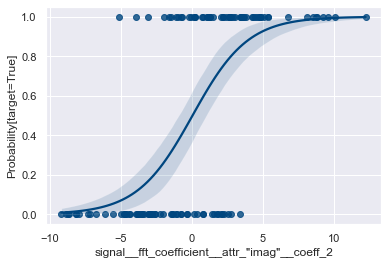

In [38]:
sns.regplot(X_eff[phi_1], target, logistic=True)
plt.ylabel('Probability[target=True]')
plt.savefig('FE15-CSP_logistic_regression_one_feature.pdf', bbox_inches='tight')

In [39]:
logreg_1D = LogisticRegression(penalty='l1', solver='saga')
logreg_1D.fit(X_eff[phi_1].values.reshape(-1, 1), target)

LogisticRegression(penalty='l1', solver='saga')

In [40]:
logreg_1D.intercept_, logreg_1D.coef_

(array([-0.01388717]), array([[0.50367441]]))

## Logistic regression with two time-series features (slide 9, FE15)

(<Figure size 432x288 with 3 Axes>,
 (<AxesSubplot:ylabel='Count'>,
  <AxesSubplot:>,
  <AxesSubplot:xlabel='signal__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"'>))

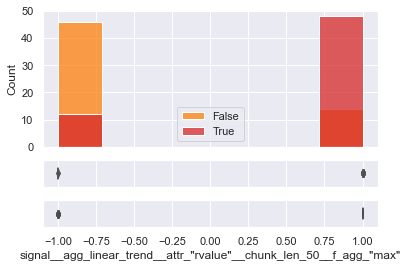

In [41]:
phi_2 = 'signal__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"'
distributions(X_eff[phi_2], target, colors=sns.color_palette("tab10"))

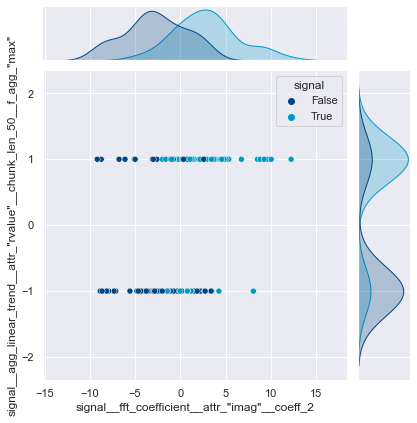

In [42]:
sns.jointplot(phi_1, 
              phi_2, 
              hue=target,
              data=X_eff_rel)
plt.savefig('FE15-CSP_logistic_regression_two_features.pdf', bbox_inches='tight')

In [43]:
def plot_decision_function(clf, X, x1, x2, y):
    x1grid = np.linspace(X[x1].min()-0.1, X[x1].max()+0.1, 100)
    x2grid = np.linspace(X[x2].min()-0.1, X[x2].max()+0.1, 100)
    clf.fit(X[[x1, x2]], target)
    xx, yy = np.meshgrid(x1grid, x2grid)
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    zz = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, zz, cmap=plt.cm.RdBu, alpha=.8)
    plt.plot(X[x1][target], X[x2][target], 'ko', label=True)
    plt.plot(X[x1][~target], X[x2][~target], 'gx', label=False)
    plt.xlabel(x1)
    plt.ylabel(x2)
    plt.colorbar()
    plt.legend()
    plt.title(str(clf))
    

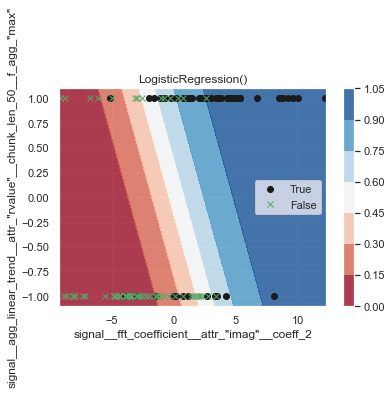

In [44]:
logreg_2D = LogisticRegression()
plot_decision_function(logreg_2D, X_eff, phi_1, phi_2, target)

plt.savefig('FE15-CSP_logistic_regression_two_features_decision_function.pdf', bbox_inches='tight')

## Decision tree with two time-series features (slide 10, FE15)

In [45]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_leaf_nodes=3)

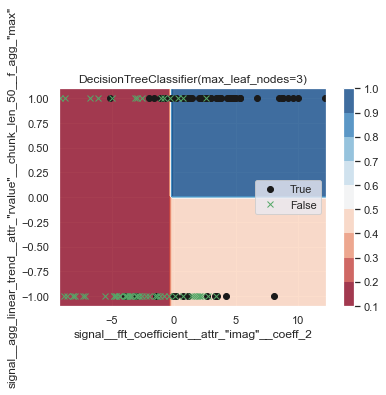

In [46]:
plot_decision_function(dtc, X_eff, phi_1, phi_2, target)

plt.savefig('FE15-CSP_decision_tree_two_features_decision_function.pdf', bbox_inches='tight')

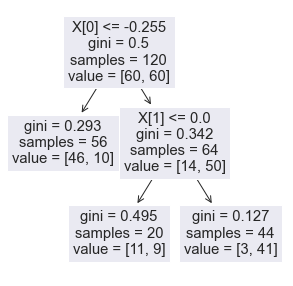

In [51]:
from sklearn.tree import plot_tree
plt.figure(figsize=(5,5))
plot_tree(dtc)
plt.savefig('FE15-CSP_decision_tree_two_features.pdf', bbox_inches='tight')
plt.show()

In [52]:
phi_1, phi_2

('signal__fft_coefficient__attr_"imag"__coeff_2',
 'signal__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"')

## Random forest with two time-series features (slide 12, FE15)

In [48]:
from sklearn.ensemble import RandomForestClassifier

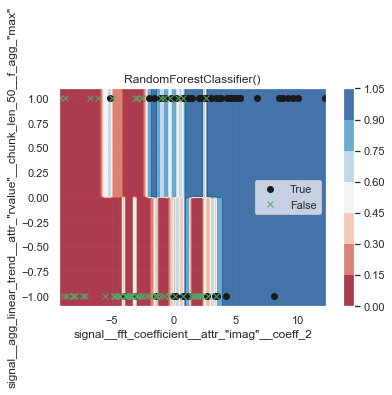

In [49]:
rfc = RandomForestClassifier()

plot_decision_function(rfc, X_eff, phi_1, phi_2, target)
plt.savefig('FE15-CSP_random_forest_two_features_decision_function.pdf', bbox_inches='tight')

In [56]:
from sklearn.model_selection import train_test_split

R_train, R_test, y_train, y_test = train_test_split(X_eff.dropna(axis=1), target,
                                                    random_state=1205)
hyper_par = np.logspace(-8, 4, 21)
auc = list()
for c in hyper_par:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(R_train, y_train)
    p = clf.predict_proba(R_test)[:,1]
    auc.append(roc_auc_score(y_test, p))
print(auc)

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9821428571428572, 0.9821428571428572, 0.9821428571428572, 1.0, 1.0, 0.9910714285714286, 0.9910714285714286, 0.9910714285714286, 0.9776785714285714, 0.9553571428571428, 0.90625, 0.9241071428571428, 0.9642857142857143, 1.0, 0.9910714285714286]


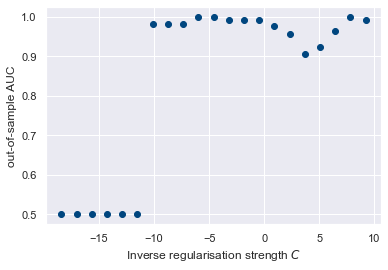

In [58]:
plt.plot(np.log(np.logspace(-8, 4, 21)), auc, 'o')
plt.xlabel('Inverse regularisation strength $C$')
plt.ylabel('out-of-sample AUC')
plt.savefig('inverse_regularization_strength.png', bbox_inches='tight')

## Exercise (slide 14, FE15)

   - Work through the notebook and understand how the figures for the slides have been generated.
   - Modify the notebook and replace the second time-series feature `phi_2` by

     `signal__fft_coefficient__attr_"imag"__coeff_5`

   - How do the decision functions of logistic regression, decision tree, and random forest change?
